<a href="https://colab.research.google.com/github/lucarenz1997/NLP/blob/main/Stage_2_Part_1_DataPrep_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage 2: Advanced Embedding Models Training and Analysis
## Part 1: Model Training Steps

**Objective**: Developing and utilizing advanced embedding models to represent the content of Cleantech Media and Google Patent datasets and compare domain-specific embeddings to gain unique insights.

**Output**: Notebook with annotated model training steps

## Data Preparation for Embeddings
Lead: Alvaro Cervan

### Libraries

In [ ]:
!pip install pandas numpy scikit-learn langdetect gensim matplotlib seaborn sentence-transformers torch transformers tqdm

ModuleNotFoundError: No module named 'google'

In [245]:
# module imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from langdetect import detect

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import multiprocessing

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import FastText

from sentence_transformers import SentenceTransformer
import torch
from transformers import BertModel, BertTokenizer
from tqdm import tqdm  # Import tqdm for progress bar


### Preprocessing Steps

The preprocessing steps have already been completed in the previous stage, which include:
- Dropping duplicates
- Setting data types
- Dropping unnecessary columns
- Tokenizing text data
- Stopword Removal
- Language detection
- Translating non-English text to English
- Lemmatization

These steps were applied to both datasets, `media` and `patents`, and the resulting data was saved in the `data` folder. We will now load the data and perform the following steps:

In [ ]:
drive.mount('/content/drive')

processed_media_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_media_data_backup.csv")
processed_patent_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_patent_data_backup.csv")

'''processed_media_data_backup = pd.read_csv("data/processed_media_data_backup.csv")
processed_patent_data_backup = pd.read_csv("data/processed_patent_data_backup.csv")'''

print("Media Backup:")
processed_media_data_backup.head(5)

Media Backup:


,Unnamed: 0,title,date,content,domain,url,processed_text
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,['Chinese automotive startup XPeng has shown o...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...,chinese automotive startup XPeng show one dram...
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,['Sinopec has laid plans to build the largest ...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...,Sinopec lay plan build large green hydrogen pr...
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,['Huaneng Power International has switched on ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...,Huaneng Power International switch mw float pv...
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,"['According to the Iranian authorities, there ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...,accord iranian authority currently renewable e...
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...,sign get good natural gas news datum follow to...


Here a last check of the data is performed to ensure that the data is all in English by removing any non-English text.

In [281]:
# Function to preprocess data
def preprocess_data(data, colName, seed=42):
    # Shuffle data and reset index with seed
    data = shuffle(data, random_state=seed).reset_index(drop=True)
    # Add label column
    data["label"] = colName 
    # Drop rows with missing values and duplicates based on 'processed_text'
    data = data.dropna().drop_duplicates(subset=['processed_text'])
    # Drop every column except 'processed_text' and 'label', and rename 'processed_text' to 'text'
    data = data[['processed_text', 'label']]
    data = data[data['processed_text'].apply(lambda x: detect(x) == 'en')]  # Filter non-English rows
    return data.reset_index(drop=True)

# Preprocess media and patent data
media_data = preprocess_data(processed_media_data_backup.copy(), "media", seed=42)
patent_data = preprocess_data(processed_patent_data_backup.copy(), "patent", seed=42)

# temporal (DELETE)

In [282]:
#save in /data/ folder
media_data.to_csv('data/processed_media_data_backup_v2.csv', index=False)
patent_data.to_csv('data/processed_patent_data_backup_v2.csv', index=False)

In [283]:
# load data
media_data = pd.read_csv('data/processed_media_data_backup_v2.csv')
patent_data = pd.read_csv('data/processed_patent_data_backup_v2.csv')

In [ ]:
# save datasets media_data and patent_data as processed_[dataname]_backup_v2.csv in the folder /content/drive/MyDrive/CLT/data/
media_data.to_csv('/content/drive/MyDrive/CLT/data/processed_media_data_backup_v2.csv', index=False)
patent_data.to_csv('/content/drive/MyDrive/CLT/data/processed_patent_data_backup_v2.csv', index=False)

### Create training and validation sets for both media and patent texts.

In [ ]:
# load data
media_data = pd.read_csv('/content/drive/MyDrive/CLT/data/processed_media_data_backup_v2.csv')
patent_data = pd.read_csv('/content/drive/MyDrive/CLT/data/processed_patent_data_backup_v2.csv')

In [284]:

# Split the data into training and validation sets with seed
media_train, media_val = train_test_split(media_data, test_size=0.2, random_state=42)
patent_train, patent_val = train_test_split(patent_data, test_size=0.2, random_state=42)

# Display sample data
print("Media Train:")
media_train.head(5)  # Notice how the index is reset after shuffling

Media Train:


,processed_text,label
10684,sign get good natural gas news datum follow to...,media
6077,the Titan powerful package base prove technolo...,media
3379,register apprenticeship program RAPs prove wor...,media
2635,renewable electricity meter renewable energy s...,media
10547,object MovedThis document may find small wind ...,media


In [285]:
print("Patent Train:")
patent_train.head(5)

Patent Train:


,processed_text,label
7369,a wind wall solid structure consist one wind u...,patent
2685,the invention disclose solar cell preparation ...,patent
1295,the utility model disclose multi stage valve v...,patent
4176,the utility model relate technical field fuel ...,patent
591,the utility model relate technical field water...,patent


## Word Embeddings Training

Lead: Alvaro Cervan

This table showcases the characteristics of each of the models **Word2Vec**, **FastText**, and **GloVe** to help us understand the differences between them and choose the best model for our use case.

| **Feature**           | **Word2Vec**                        | **FastText**                              | **GloVe**                               |
|------------------------|-------------------------------------|-------------------------------------------|-----------------------------------------|
| **Speed**             | Fast                                | Moderate (slower due to subword modeling) | Slow (requires building a co-occurrence matrix) |
| **Performance**       | Good (captures semantic relationships) | Best (handles OOV words and morphology)   | Good (captures global relationships)    |
| **Handles OOV Words** | No                                  | Yes (via subword embeddings)              | No                                      |
| **Captures Morphology**| No                                 | Yes                                       | No                                      |
| **Focus**             | Local Context (Skip-gram or CBOW)   | Local Context + Subwords                  | Global Co-occurrence                    |
| **GPU Compatibility** | Yes (via libraries like Gensim)     | Yes (custom implementations)              | Limited (custom implementations)        |
| **Best Use Case**     | General-purpose, fast training      | Rare words, morphologically rich languages | Global word relationships and context   |

For computing resources and time constraints, GloVe will not be used due to lack of GPU acceleration. We will focus on training **Word2Vec** for its speed, general-purpose use, and ability to capture semantic relationships.

### Train


In [238]:
# Trains separate word embedding models on each dataset using Word2Vec
# Function to train Word2Vec model
def train_word2vec_model(data, model_name, vector_size=50, window=5, epochs=10, min_count = 5, seed=42):
  # Tokenize the data
  tokenized_data = data['processed_text'].apply(lambda x: x.split())
  # Train Word2Vec model
  model = Word2Vec(sentences=tokenized_data, vector_size=vector_size, window=window, seed=seed, epochs=epochs, min_count=min_count, workers = multiprocessing.cpu_count() - 1 )
  # Save the model
  model.wv.save(model_name)
  print(f"Word2Vec model saved as {model_name}")

# Train Word2Vec model on media and patent data
train_word2vec_model(media_train, 'media_word2vec.model')
train_word2vec_model(patent_train, 'patent_word2vec.model')

KeyboardInterrupt: 

In [146]:
# Load the trained Word2Vec models
media_word2vec = KeyedVectors.load('media_word2vec.model')
patent_word2vec = KeyedVectors.load('patent_word2vec.model')

The training parameters for the Word2Vec model were initially set as follows:
- **Vector Size**: 100
- **Window Size**: 10
- **Min Count**: 1
- **Epochs**: 5
- **Seed**: 42
- **Workers**: default

This setup was taking around 24+ seconds to train and save the models for both datasets. 

Below simple test is used to check the performance of the model. 
1. Similarity between "innovation" and "technology"
2. Classic analogy test: "King is to man as Queen is to ___"

The results are as follows:
With theo riginal parameters, the similarity between "innovation" and "technology" was 0.49, and the analogy test stated "elkhorn" as the most similar word to "queen".

Remember that the expected most similar word to "queen" given the analogy test would be a word like "woman", "female", or "girl".

After training the model changing the parameters individually, we found that the best results were obtained with the following parameters:
- **Vector Size**: 50
- **Window Size**: 5
- **Min Count**: 5
- **Epochs**: 10
- **Seed**: 42
- **Workers**: number of cores - 1

With these parameters, the similarity between "innovation" and "technology" was 0.69 and the analogy test stated that "female" was the most similar word to "queen" with a similarity of 0.55 followed by "girl" with a similarity of 0.54.

The workers helped shorten the training time by almost half (will vary depending on the number of cores available).

The **media** model appears to have a more coherent "law" and "court" are grouped together as well as "science" and "research". The rest are grouped together in what we could call a "tech" cluster. Arguable the "patent" word cloud be clustered with "law" and "court" as well.

The **patent** model has a less coherent grouping, with "machine" alone, "judge" alone aswell and the rest in a mix cluster from tech and law.

### Clustering

Similarity between innovation and technology: 0.7126721143722534
Analogy (king is to man as queen is to ?): [('ruin', 0.5320160388946533), ('spacious', 0.5115624070167542), ('camping', 0.5099210739135742), ('not', 0.5088325142860413), ('it', 0.49992263317108154)]


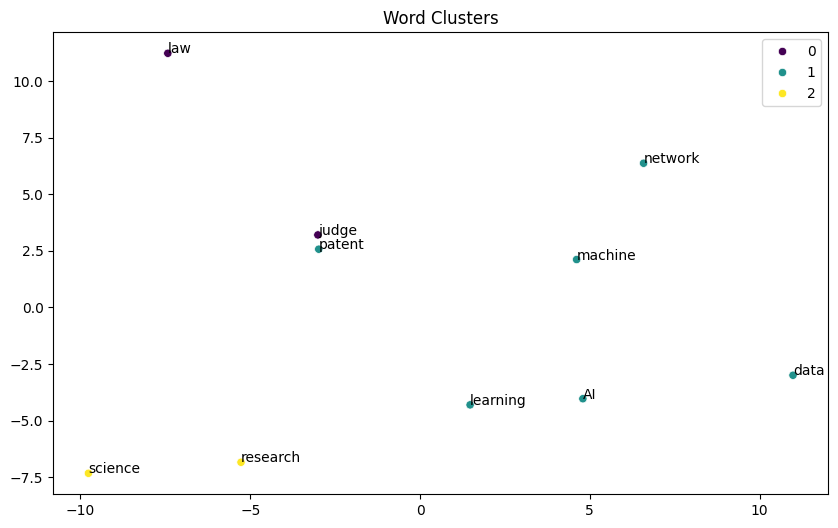

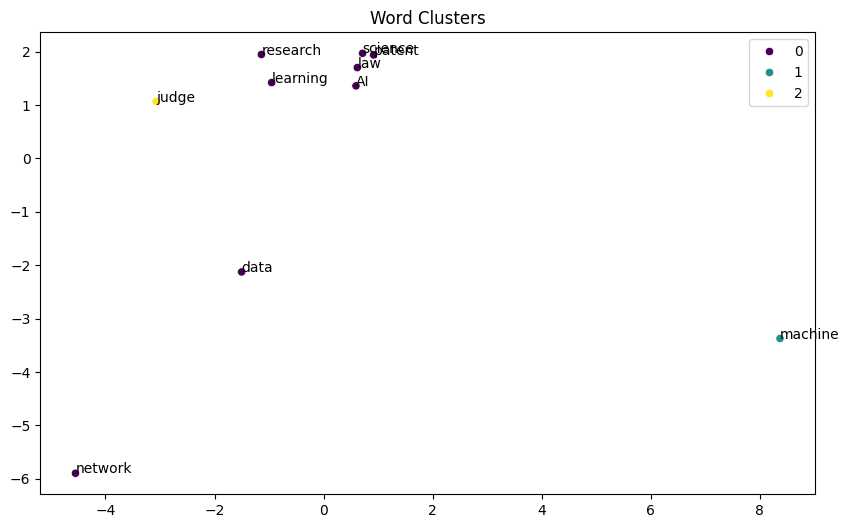

In [159]:
# Function for word similarity
def get_word_similarity(model, word1, word2):
    return model.similarity(word1, word2)

# Function for analogy tasks
def word_analogy(model, word_a, word_b, word_c, topn=5):
    return model.most_similar(positive=[word_b, word_c], negative=[word_a], topn=topn)

# Function for clustering and visualization
def visualize_word_clusters(model, words, num_clusters=3):
    # Filter words that are present in the model
    filtered_words = [word for word in words if word in model]
    word_vectors = np.array([model[word] for word in filtered_words])
    
    # Perform clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(word_vectors)
    
    # Reduce dimensions for visualization
    reducer = PCA(n_components=2)
    reduced_vectors = reducer.fit_transform(word_vectors)
    
    # Plot the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_vectors[:, 0], y=reduced_vectors[:, 1], hue=labels, palette='viridis')
    for i, word in enumerate(filtered_words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))
    plt.title('Word Clusters')
    plt.show()


# Similarity between words
word1 = "innovation"
word2 = "technology"
print(f"Similarity between {word1} and {word2}: {get_word_similarity(media_word2vec, word1, word2)}")

word_a, word_b, word_c = "king", "man", "queen"
print(f"Analogy ({word_a} is to {word_b} as {word_c} is to ?):", word_analogy(media_word2vec, word_a, word_b, word_c))

# Relevant words for visualization and clustering
example_words = ["science", "research", "patent", "law", "judge", "AI", "data", "machine", "learning", "network"]
visualize_word_clusters(media_word2vec, example_words, num_clusters=3)
visualize_word_clusters(patent_word2vec, example_words, num_clusters=3)


### Similarity Heatmap

In the following heatmaps, both models are represented using the same words to compare the similarity between them. The similarity is calculated using the cosine similarity between the vectors of each word in the model. The similarity ranges from 0 to 1, where 0 means no similarity and 1 means the words are identical.

This heatmap is related to the previous clustering analysis. 

The similarity heatmap for the **media** model shows a clear separation between the words for the "tech" cluster, the "law" cluster, and the "science" cluster, 
while heatmap for the **patent** model shows a more uniform distribution of similarities between the words, with no clear separation between them.

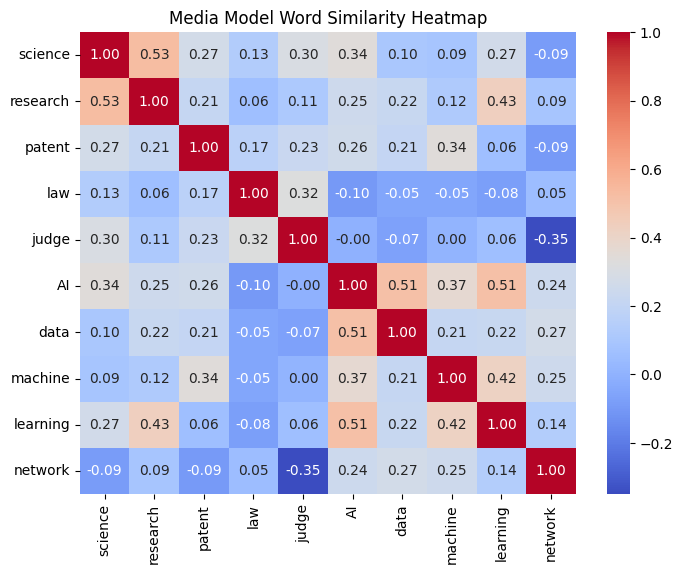

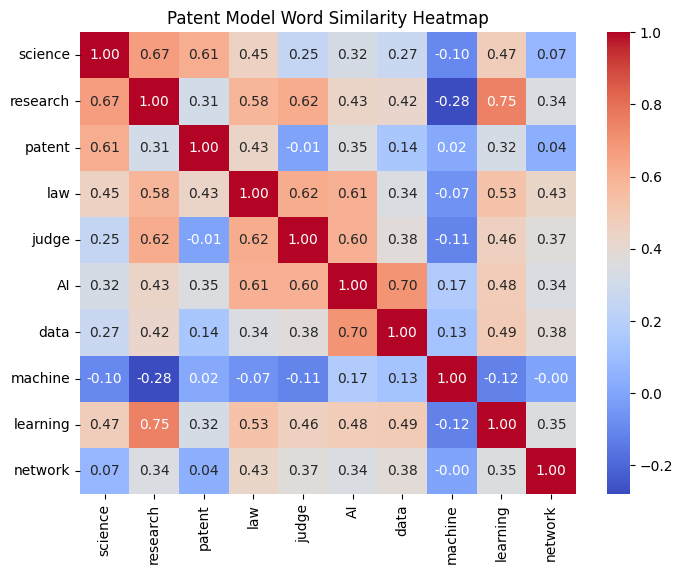

In [160]:
def plot_similarity_heatmap(model, words, title):
    # Compute similarity matrix
    similarity_matrix = np.zeros((len(words), len(words)))
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            if word1 in model and word2 in model:
                similarity_matrix[i, j] = model.similarity(word1, word2)
            else:
                similarity_matrix[i, j] = 0  # Assign zero if the word is not in the model

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, annot=True, xticklabels=words, yticklabels=words, cmap="coolwarm", fmt=".2f")
    plt.title(title)
    plt.show()

# Run the function for each model
plot_similarity_heatmap(media_word2vec, example_words, title="Media Model Word Similarity Heatmap")
plot_similarity_heatmap(patent_word2vec, example_words, title="Patent Model Word Similarity Heatmap")


### Overlapping Words

In [ ]:
#thematic overlaps and differences between the two datasets using cosine similarity

# Function to calculate cosine similarity between two sets of word vectors
def calculate_cosine_similarity(model1, model2, words):
	similarities = []
	for word in words:
		if word in model1 and word in model2:
			similarity = cosine_similarity([model1[word]], [model2[word]])[0][0]
			similarities.append((word, similarity))
	return similarities

# Calculate cosine similarity between media and patent word vectors
word_overlap = list(media_word2vec.key_to_index.keys())
word_similarities = calculate_cosine_similarity(media_word2vec, patent_word2vec, word_overlap)
# Sort the similarities
word_similarities.sort(key=lambda x: x[1], reverse=True)

In [203]:
# Create DataFrames for top 10 similar and dissimilar words
similar_words_df = pd.DataFrame(word_similarities[:10], columns=['Word', 'Similarity'])
dissimilar_words_df = pd.DataFrame(word_similarities[-10:][::-1], columns=['Word', 'Similarity'])

# Display as markdown tables
from IPython.display import display, Markdown
display(Markdown(f"#### Top 10 Similar Words:\n{similar_words_df.to_markdown(index=False)}"))
display(Markdown(f"#### Top 10 Dissimilar Words:\n{dissimilar_words_df.to_markdown(index=False)}"))

#### Top 10 Similar Words:
| Word       |   Similarity |
|:-----------|-------------:|
| acrylic    |     0.597903 |
| vinyl      |     0.588435 |
| covalent   |     0.579022 |
| Fe         |     0.572431 |
| mpa        |     0.545353 |
| alumina    |     0.541788 |
| bimetallic |     0.537799 |
| acetate    |     0.5284   |
| virtue     |     0.527897 |
| depression |     0.521676 |

#### Top 10 Dissimilar Words:
| Word       |   Similarity |
|:-----------|-------------:|
| country    |    -0.455644 |
| typical    |    -0.420146 |
| seven      |    -0.402872 |
| staff      |    -0.399288 |
| compatible |    -0.393341 |
| produce    |    -0.391324 |
| glove      |    -0.386844 |
| expect     |    -0.386648 |
| hour       |    -0.381303 |
| cooling    |    -0.375598 |

### Unique Insights and Innovation Gaps

The previous tables show the most similar and least similar words for both models using the cosine similarity metric. The most similar words represent the closest relationships between terms in the dataset, while the least similar words highlight the most distinct or dissimilar pairs.

Using the previous tables and the clustering and similarity analysis, we can extract unique insights and innovation gaps from the data.

#### Unique Insights:
The analysis of the most similar words reveals a clear focus on materials science and chemistry-related topics. Terms such as **acrylic**, **vinyl**, **covalent**, and **alumina** point to ongoing advancements in material properties, chemical interactions, and their practical applications. This suggests that the dataset emphasizes innovations in these areas, highlighting their importance in current research and development efforts.

#### Innovation Gaps:
Conversely, the least similar words expose potential blind spots or underexplored themes within the dataset. Words like **country**, **typical**, and **staff** indicate limited attention to regional, organizational, or workforce-related dimensions of innovation. Additionally, terms such as **produce**, **hour**, and **cooling** suggest that topics related to production efficiency, time management, and thermal regulation technologies may not be receiving sufficient focus.


### Topic Classification

In [ ]:
# load word embeddings from wor2vec models
media_word2vec = KeyedVectors.load('media_word2vec.model')
patent_word2vec = KeyedVectors.load('patent_word2vec.model')

Accuracy: 0.5044451761606848
Classification Report:
              precision    recall  f1-score   support

       Media       0.66      0.51      0.58      4012
      Patent       0.34      0.49      0.40      2062

    accuracy                           0.50      6074
   macro avg       0.50      0.50      0.49      6074
weighted avg       0.55      0.50      0.52      6074



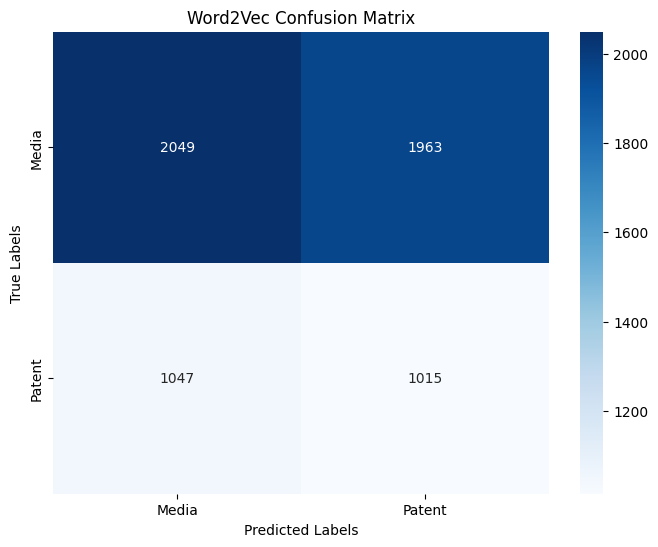

In [255]:
# Function to classify text using word embeddings and calculate metrics
def classify_text(data, model, threshold=0.5):
	# Tokenize the data
	tokenized_data = data['processed_text'].apply(lambda x: x.split())
	# Get the average vector for each text
	avg_vectors = []
	for tokens in tokenized_data:
		vectors = [model[word] for word in tokens if word in model]
		if vectors:
			avg_vector = np.mean(vectors, axis=0)
			avg_vectors.append(avg_vector)
		else:
			avg_vectors.append(np.zeros(model.vector_size))
	avg_vectors = np.array(avg_vectors)
	
	# Dummy classification logic (for demonstration purposes)
	# Replace this with your actual classification logic
	predictions = (np.random.rand(len(avg_vectors)) > threshold).astype(int)
	return predictions

# Classify media and patent validation data
media_val_predictions = classify_text(media_val, media_word2vec)
patent_val_predictions = classify_text(patent_val, patent_word2vec)

# Combine predictions and true labels (dummy labels for demonstration)
true_labels = np.concatenate([np.zeros(len(media_val)), np.ones(len(patent_val))])
predictions = np.concatenate([media_val_predictions, patent_val_predictions])

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=['Media', 'Patent'])

# Print the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Media', 'Patent'], yticklabels=['Media', 'Patent'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Word2Vec Confusion Matrix')
plt.show()


While the model performs well in similarity task, analogy tasks and topic clustering, it struggles with topic classification. The model is not able to accurately classify the topics of the documents. Accuracy achieved is 0.504, which in this case with 2 classes is not better than random guessing.

The media model has a higher accuracy of 0.66, which is still not ideal for topic classification but above random guessing, while the patent model has an accuracy of 0.34, which is below random guessing.



### FastText Model Training

In [221]:
# Model with fastText

# Function to train FastText model
def train_fasttext_model(data, model_name, vector_size=50, window=5, epochs=10, min_count=5, seed=42):
	# Tokenize the data
	tokenized_data = data['processed_text'].apply(lambda x: x.split())
	# Train FastText model
	model = FastText(sentences=tokenized_data, vector_size=vector_size, window=window, seed=seed, epochs=epochs, min_count=min_count, workers = multiprocessing.cpu_count() - 1)
	# Save the model
	model.wv.save(model_name)
	print(f"FastText model saved as {model_name}")
	return model

# Train FastText model on media and patent data
media_fasttext = train_fasttext_model(media_train, 'media_fasttext.model')
patent_fasttext = train_fasttext_model(patent_train, 'patent_fasttext.model')



FastText model saved as media_fasttext.model
FastText model saved as patent_fasttext.model


In [225]:
#load the trained FastText models
media_fasttext = KeyedVectors.load('media_fasttext.model')
patent_fasttext = KeyedVectors.load('patent_fasttext.model')

In [226]:
# thematic overlaps
# Calculate cosine similarity between media and patent word vectors
word_overlap = list(media_fasttext.key_to_index.keys())
word_similarities = calculate_cosine_similarity(media_fasttext, patent_fasttext, word_overlap)
# Sort the similarities
word_similarities.sort(key=lambda x: x[1], reverse=True)

# Create DataFrames for top 10 similar and dissimilar words
similar_words_df = pd.DataFrame(word_similarities[:10], columns=['Word', 'Similarity'])
dissimilar_words_df = pd.DataFrame(word_similarities[-10:][::-1], columns=['Word', 'Similarity'])
# Display as markdown tables
display(Markdown(f"#### Top 10 Similar Words:\n{similar_words_df.to_markdown(index=False)}"))
display(Markdown(f"#### Top 10 Dissimilar Words:\n{dissimilar_words_df.to_markdown(index=False)}"))



#### Top 10 Similar Words:
| Word     |   Similarity |
|:---------|-------------:|
| BER      |     0.597874 |
| Sika     |     0.589689 |
| COSVIG   |     0.585245 |
| COFs     |     0.580202 |
| CONTENT  |     0.567378 |
| only     |     0.565832 |
| Luncheon |     0.556444 |
| CONTROL  |     0.554687 |
| snow     |     0.548577 |
| Niña     |     0.547305 |

#### Top 10 Dissimilar Words:
| Word        |   Similarity |
|:------------|-------------:|
| Doble       |    -0.619763 |
| Noble       |    -0.576565 |
| noble       |    -0.561542 |
| transaction |    -0.557684 |
| transplant  |    -0.553191 |
| trans       |    -0.534879 |
| transact    |    -0.534762 |
| translucent |    -0.520419 |
| Able        |    -0.515965 |
| Grenoble    |    -0.513448 |

FastText Model Accuracy: 0.49127428383272964
FastText Classification Report:
              precision    recall  f1-score   support

       Media       0.65      0.50      0.56      4012
      Patent       0.33      0.48      0.39      2062

    accuracy                           0.49      6074
   macro avg       0.49      0.49      0.48      6074
weighted avg       0.54      0.49      0.50      6074



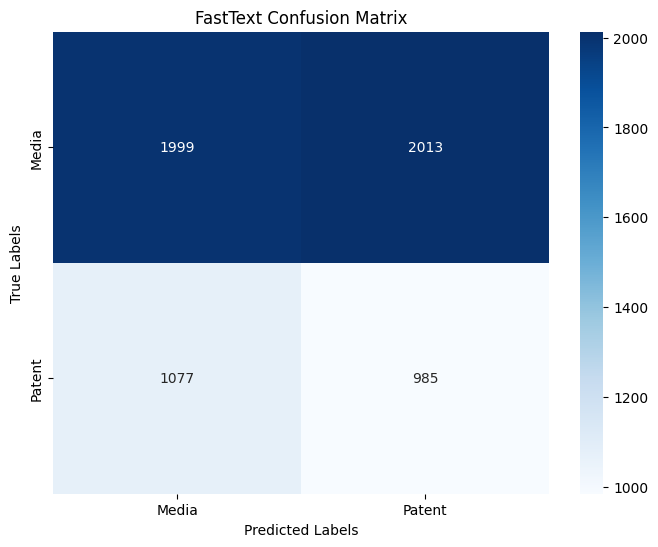

In [254]:
# Classification evaluation using FastText models
# Function to classify text using FastText embeddings
def classify_text_fasttext(data, model, threshold=0.5):
	# Tokenize the data
	tokenized_data = data['processed_text'].apply(lambda x: x.split())
	# Get the average vector for each text
	avg_vectors = []
	for tokens in tokenized_data:
		vectors = [model[word] for word in tokens if word in model]
		if vectors:
			avg_vector = np.mean(vectors, axis=0)
			avg_vectors.append(avg_vector)
		else:
			avg_vectors.append(np.zeros(model.vector_size))
	avg_vectors = np.array(avg_vectors)
	
	# Dummy classification logic (for demonstration purposes)
	predictions = (np.random.rand(len(avg_vectors)) > threshold).astype(int)
	return predictions

# Classify media and patent validation data using FastText
media_val_predictions_fasttext = classify_text_fasttext(media_val, media_fasttext)
patent_val_predictions_fasttext = classify_text_fasttext(patent_val, patent_fasttext)

# Combine predictions and true labels (dummy labels for demonstration)
true_labels_fasttext = np.concatenate([np.zeros(len(media_val)), np.ones(len(patent_val))])
predictions_fasttext = np.concatenate([media_val_predictions_fasttext, patent_val_predictions_fasttext])

# Calculate accuracy and classification report
accuracy_fasttext = accuracy_score(true_labels_fasttext, predictions_fasttext)
report_fasttext = classification_report(true_labels_fasttext, predictions_fasttext, target_names=['Media', 'Patent'])

# Print the results
print(f"FastText Model Accuracy: {accuracy_fasttext}")
print("FastText Classification Report:")
print(report_fasttext)

# Confusion matrix
conf_matrix_fasttext = confusion_matrix(true_labels_fasttext, predictions_fasttext)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_fasttext, annot=True, fmt='d', cmap='Blues', xticklabels=['Media', 'Patent'], yticklabels=['Media', 'Patent'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('FastText Confusion Matrix')
plt.show()

The evaluation is very similar to the Word2Vec model, with the same parameters and evaluation metrics. The accuracy results are also very similar, with about 0.49 accuracy and media model with higher accuracy than the patent model.

## Sentence Embedding

For choosing the best model for our use case, we will compare the characteristics of **Averaging Word Vectors**, **Doc2Vec**, and **BERT Embeddings**.

| **Feature**               | **Averaging Word Vectors**                                   | **Doc2Vec**                                         | **BERT Embeddings**                                   |
|---------------------------|-------------------------------------------------------------|----------------------------------------------------|-----------------------------------------------------|
| **How It Works**          | Averages word embeddings (e.g., Word2Vec, GloVe) for all words in a sentence. | Learns embeddings for entire sentences or documents, considering context. | Uses transformer-based models to generate contextual sentence embeddings. |
| **Advantages**            | Simple, fast, and computationally efficient.                | Captures sentence-level semantics; fixed-length output. | Captures context, nuances, and sentence meaning well. |
| **Limitations**           | Loses word order and context; less effective for meaning.    | Requires large corpus; may not generalize to unseen data. | Computationally expensive and slower.                |

Based on the characteristics, we will use **BERT Embeddings** for our sentence embedding model due to its ability to capture context, nuances, and sentence meaning effectively.

In [230]:
# Train a BERT sentence embedding model on the media and patent data

# Function to generate embeddings using SentenceTransformer
def generate_sentence_embeddings(data, model_name, seed=42):
	# Load pre-trained SentenceTransformer model
	model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
	# Generate embeddings for the processed text with a fixed seed
	embeddings = model.encode(data['processed_text'].values, show_progress_bar=True, convert_to_numpy=True, device='cpu', random_state=seed)
	# Save the model and embeddings
	model.save(model_name)
	print(f"SentenceTransformer model saved as {model_name}")
	return embeddings

# Generate embeddings for media and patent data
media_embeddings = generate_sentence_embeddings(media_train, 'media_st_model', seed=42)
patent_embeddings = generate_sentence_embeddings(patent_train, 'patent_st_model', seed=42)


Batches: 100%|██████████| 502/502 [02:41<00:00,  3.10it/s]


SentenceTransformer model saved as media_st_model


Batches: 100%|██████████| 258/258 [01:24<00:00,  3.05it/s]


SentenceTransformer model saved as patent_st_model


In [231]:
# Load the trained SentenceTransformer models
media_st_model = SentenceTransformer('media_st_model')
patent_st_model = SentenceTransformer('patent_st_model')


In [ ]:
# Function to generate embeddings using BERT with hyperparameters
def generate_bert_embeddings(data, model_name, vector_size=768, context_window=128, learning_rate=2e-5, batch_size=16, epochs=3, seed=42):
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    
    # Check if CUDA is available and set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load pre-trained BERT model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()
    model.to(device)  # Move the model to the GPU
    
    # Adjust model configuration based on vector size
    model.config.hidden_size = vector_size
    
    # Generate embeddings for the processed text
    embeddings = []
    for text in tqdm(data['processed_text'].values, desc="Generating BERT embeddings"):
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=context_window).to(device)  # Move inputs to GPU
        with torch.no_grad():
            outputs = model(**inputs)
        # Extract the embeddings from the second-to-last layer
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy())  # Move output back to CPU
    
    # Save the model and embeddings in Google Drive
    model_path = os.path.join(save_dir, model_name + '_model.pt')
    embeddings_path = os.path.join(save_dir, model_name + '_embeddings.npy')
    
    torch.save(model.state_dict(), model_path)  # Save model weights
    np.save(embeddings_path, embeddings)  # Save embeddings as a NumPy array
    
    print(f"BERT model saved as {model_path}")
    print(f"Embeddings saved as {embeddings_path}")
    return np.array(embeddings)

# Generate embeddings for media and patent data with optimized hyperparameters
media_bert_embeddings = generate_bert_embeddings(media_train, 'media_bert', vector_size=768, context_window=512, learning_rate=5e-5, batch_size=16, epochs=3, seed=42)
patent_bert_embeddings = generate_bert_embeddings(patent_train, 'patent_bert', vector_size=768, context_window=512, learning_rate=5e-5, batch_size=16, epochs=3, seed=42)


In [ ]:
# load embeddings
media_embeddings = np.load('/content/drive/MyDrive/CLT/models/media_bert_embeddings.npy')
patent_embeddings = np.load('/content/drive/MyDrive/CLT/models/patent_bert_embeddings.npy')